# Introduction
In the following you will see how to read the provided files for the mini-project 3.
First you will see how to read each of the provided files. Then, you will see a more elegant way of using this data for training neural networks.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive' )

%cd '/content/gdrive/MyDrive/Colab Notebooks/Mini Project 3 ECSE 551 Team 20'

import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1RXjBzfMRON_UZYkUp9X2psOg0iYCNREW/Mini Project 3 ECSE 551 Team 20


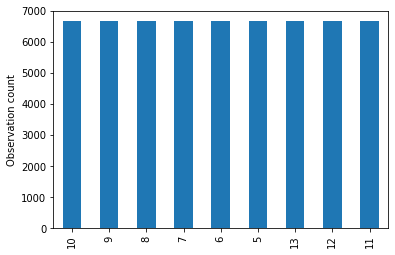

10    6667
9     6667
8     6667
7     6667
6     6667
5     6667
13    6666
12    6666
11    6666
Name: class, dtype: int64
Each class has the same number of observation ±1 data
(60000, 64, 128) (60000, 1)


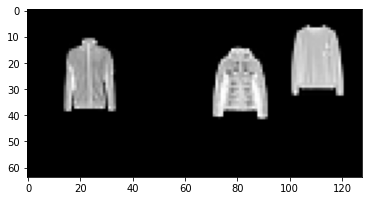

In [2]:
"""
Let's see how the data looks like.
"""

import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("./TrainLabels.csv")

fig = plt.figure()
train['class'].value_counts().plot.bar()
plt.ylabel("Observation count")
plt.show()

print((train['class'].value_counts()))

print("Each class has the same number of observation ±1 data")

# Read a pickle file and dispaly its samples
# Note that image data are stored as unit8 so each element is an integer value between 0 and 255
data = pickle.load( open( './Train.pkl', 'rb' ), encoding='bytes')
targets = np.genfromtxt('./TrainLabels.csv', delimiter=',', skip_header=1)[:,1:]
plt.imshow(data[1234,:,:],cmap='gray', vmin=0, vmax=256)
print(data.shape, targets.shape)

# Dataset class
*Dataset* class and the *Dataloader* class in pytorch help us to feed our own training data into the network. Dataset class is used to provide an interface for accessing all the training or testing samples in your dataset. For your convinance, we provide you with a custom Dataset that reads the provided data including images (.pkl file) and labels (.csv file).

# Dataloader class
Although we can access all the training data using the Dataset class, for neural networks, we would need batching, shuffling, multiprocess data loading, etc. DataLoader class helps us to do this. The DataLoader class accepts a dataset and other parameters such as batch_size.

In [14]:
training_phase = True
export = False
idx_input = None
"""
If in training phase, set the following parameters 
"""

train_size = 48000 
test_size = 12000

batch_size = 2 ** 7 #feel free to change it

#Optimizer calibratable hyper parameters
c_lr = 0.05
c_momentum = 0.5

#Network iteration calibratable paramerters
n_epochs = 2

In [4]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [5]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, targets, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = targets
        # self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        if transform is not None:
          self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img, target

In [7]:
# Read image data and their label into a Dataset class

if training_phase:
  print("Training phase dataset generation")
  # Split the data into the training set and the test set
  from sklearn.model_selection import ShuffleSplit
  SS = ShuffleSplit(n_splits=1, train_size=train_size, test_size=test_size, random_state=28)
  targets = np.genfromtxt('./TrainLabels.csv', delimiter=',', skip_header=1)[:,1:]
  train_index, test_index = next(SS.split(targets)) 

  #Create the train dataset
  target_csv = np.genfromtxt('./TrainLabels.csv', delimiter=',', skip_header=1)[:,1:]
  min_target = min(target_csv)
  target_csv = target_csv - min_target

  train_dataset = MyDataset('./Train.pkl', target_csv, idx=train_index, transform=img_transform)
  test_dataset = MyDataset('./Train.pkl', target_csv, idx=test_index, transform=img_transform)
  #test_dataset = MyDataset('./Train.pkl', './TrainLabels.csv', idx=test_index, transform=img_transform)

  # Targets range starting at 0
  # print(min(train_dataset.targets))
  # print(min(test_dataset.targets))

  # min_target = min(min(train_dataset.targets), min(test_dataset.targets))
  # train_dataset.targets = train_dataset.targets - min_target
  # test_dataset.targets = test_dataset.targets - min_target

  #Apply the dataloader
  train_loader = DataLoader(train_dataset ,batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset ,batch_size=batch_size, shuffle=True)


else:
  print("Not in training phase")
  print("Dataset class needs to be modified for the test phase, since it needs label input, but we still want the transform (normalization..)")
  train_dataset = MyDataset('./Train.pkl', './TrainLabels.csv', idx=None, transform=img_transform)

  min_target = min(train_dataset.targets)
  train_dataset.targets = train_dataset.targets - min_target

  train_loader = DataLoader(train_dataset ,batch_size=1, shuffle=True)

  data = pickle.load( open( './Test.pkl', 'rb' ), encoding='bytes')
  test_loader = DataLoader(data ,batch_size=1, shuffle=False)  


Training phase dataset generation


torch.Size([128, 64, 128])


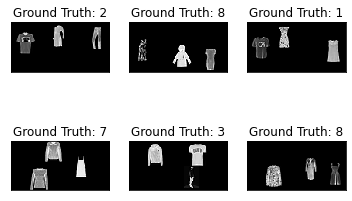

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data = np.squeeze(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  #plt.tight_layout()
  plt.imshow(example_data[i].cpu().numpy(), cmap='gray', vmin=-1, vmax=1, interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig
print(example_data.shape)

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class Net(nn.Module):
    # This part defines the layers
    def __init__(self):
        super(Net, self).__init__()
        # At first there is only 1 channel (greyscale). The next channel size will be 10. 
        input_sz_h = 128
        input_sz_v = 64
        fltr_sz_cv_1 = 3
        fltr_num_cv_1 = 10
        fltr_sz_cv_2 = 3
        fltr_num_cv_2 = 10
        final_sz_h = np.floor(((input_sz_h-fltr_sz_cv_1+1)/2-fltr_sz_cv_2+1)/2)
        final_sz_v = np.floor(((input_sz_v-fltr_sz_cv_1+1)/2-fltr_sz_cv_2+1)/2)
        self.img_sz = int(fltr_num_cv_2 * final_sz_h * final_sz_v)

        self.conv1 = nn.Conv2d(1, fltr_num_cv_1, kernel_size=fltr_sz_cv_1)
        self.conv2 = nn.Conv2d(fltr_num_cv_1, fltr_num_cv_2, kernel_size=fltr_sz_cv_2)
        self.conv2_drop = nn.Dropout2d()


        NN_neurons = 120
        self.fc1 = nn.Linear(self.img_sz, NN_neurons)
        self.fc2 = nn.Linear(NN_neurons, 9)

    # And this part defines the way they are connected to each other
    # (In reality, it is our foreward pass)
    def forward(self, x):
        

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, self.img_sz)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x,dim=0)

In [11]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=c_lr, momentum=c_momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs+1)]
predi = []

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    target = target.to(device)
    data = data.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target) #negative log liklhood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  predi = []
  with torch.no_grad():
    for data, target in test_loader:
      
      target = target.to(device)
      data = data.to(device)     
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      predi.append(pred)
      #print(pred)
  # print(len(predi[0]))
  # print(len(predi)) # this should

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return pred, predi

In [15]:
test()

for epoch in range(1, n_epochs+1):
  train(epoch)
  pred, predi = test()
 

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 4.7683, Accuracy: 2184/12000 (18%)

Train Epoch: 1 [0/48000 (0%)]	Loss: 4.789583
Train Epoch: 1 [2560/48000 (5%)]	Loss: 4.765519
Train Epoch: 1 [5120/48000 (11%)]	Loss: 4.746111
Train Epoch: 1 [7680/48000 (16%)]	Loss: 4.750994
Train Epoch: 1 [10240/48000 (21%)]	Loss: 4.752915
Train Epoch: 1 [12800/48000 (27%)]	Loss: 4.712166
Train Epoch: 1 [15360/48000 (32%)]	Loss: 4.742738
Train Epoch: 1 [17920/48000 (37%)]	Loss: 4.782693
Train Epoch: 1 [20480/48000 (43%)]	Loss: 4.718966
Train Epoch: 1 [23040/48000 (48%)]	Loss: 4.759154
Train Epoch: 1 [25600/48000 (53%)]	Loss: 4.662666
Train Epoch: 1 [28160/48000 (59%)]	Loss: 4.677700
Train Epoch: 1 [30720/48000 (64%)]	Loss: 4.719402
Train Epoch: 1 [33280/48000 (69%)]	Loss: 4.718292
Train Epoch: 1 [35840/48000 (75%)]	Loss: 4.694878
Train Epoch: 1 [38400/48000 (80%)]	Loss: 4.643548
Train Epoch: 1 [40960/48000 (85%)]	Loss: 4.647663
Train Epoch: 1 [43520/48000 (91%)]	Loss: 4.632878
Train Epoch: 1 [46080/48000 (96%)]	Loss: 4.665687



In [21]:
print(len(test_counter))
print(len(test_losses))

51
7


ValueError: ignored

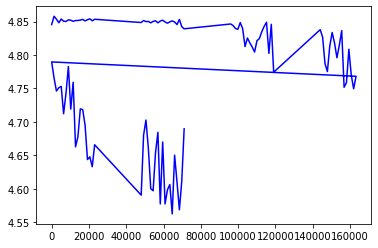

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
"""
This creates a single list out of the Predi variable.
Since Predi is a nested list, each elements are appended to the new list predictions
Since the batch size doesnt exactly count for the total number of values,
this deletes all values above the size of the test_dataset
"""

batch_size = len(predi[0])
test_size = len(test_dataset)


predictions = []
for list in predi:
    for item in list:
      predictions.append(item.item() + min_target)
#print(len(predictions))

del predictions[test_size:]
#print(len(predictions))
#print(predictions)

"""
Create a Pandas Datafram to see the data
It is also easier to export
"""

result=pd.DataFrame(predictions)
result.reset_index(level=0, inplace=True)
result.columns = ["id","class"]

#print(predi[0][0].item())

fig = plt.figure()
result['class'].value_counts().plot.bar()
plt.ylabel("Observation count")
plt.show()

In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
"""
Let's build a confusion matrix
"""
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(test_dataset.targets + min_target, predictions)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d')

# sns.heatmap(conf_mat, annot=True, fmt='d',
#             xticklabels=test_dataset.targets, yticklabels=test_dataset.targets)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:


if export:
  # Export function to a CSV and downloads to local machine
  from google.colab import files
  import pandas as pd


  result.to_csv("ECSE551_Group20.csv",index=False)
  files.download("ECSE551_Group20.csv")